In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.visualization import make_lupton_rgb
import numpy as np
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import cv2
from detectron2.structures import BoxMode
from astropy.table import Table
import glob
from astropy.coordinates import SkyCoord  # High-level coordinates
from detectron2.config import LazyConfig, get_cfg, instantiate
import os
import scipy.stats as stats
import h5py
import json
import astropy.units as u
from astropy.coordinates import SkyCoord

import warnings
import time

from astropy.wcs import FITSFixedWarning
warnings.filterwarnings("ignore", category=FITSFixedWarning)
import torch
import torch.nn.functional as F
from detectron2.data import detection_utils as utils
import pickle
from sklearn.utils import resample
from matplotlib import gridspec


In [6]:
20/((0.0575*525/60)**2/3600)

284433.4709309054

In [4]:
60*60

3600

In [3]:
with open('/home/shared/hsc/roman_lsst/lsst_data/annotations_lvl2/test.json', 'r') as f:
    test_ddicts = json.load(f)
    
dtruth_test = pd.read_csv('/home/g4merz/DeepDISC_Roman_Rubin/data/dtest_truth.csv')

In [10]:
def smooth_loss(losses, weight: float):  # Weight between 0 and 1
    last = losses[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in losses:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


    

In [11]:
def get_losses(run_name,lossdir='/home/g4merz/JWST/models/kfold/'):
    with open(os.path.join(lossdir,f'{run_name}_losses.json'), 'r') as jsonfile:
        losses = json.load(jsonfile)
    with open(os.path.join(lossdir,f'{run_name}_val_losses.json'), 'r') as jsonfile:
        val_losses = json.load(jsonfile)


    total_losses = []
    ztrain_losses = []

    for key, eloss in losses.items():
        total_losses.append(sum([val for key, val in eloss.items()]))
        ztrain_losses.append(eloss['redshift_loss'])
    total_losses = np.array(total_losses)


    total_val_losses = []
    zval_losses = []
    for key, eloss in val_losses.items():
        total_val_losses.append(sum([val for key, val in eloss.items()]))
        zval_losses.append(eloss['redshift_loss'])

    total_val_losses = np.array(total_val_losses)
    
    return total_losses, ztrain_losses, total_val_losses, zval_losses



def plot_single_loss(tl,ztl,tvl,zvl,epochs=150,ipb=106):
    fig, ax = plt.subplots(figsize=(7,6))
    iters = np.arange(0.5,epochs+0.5,0.5)*ipb
    xticks = np.linspace(0,epochs,11)*ipb+1

    w=0.8
    stl = smooth_loss(tl,w)
    sztl = smooth_loss(ztl,w)
    stvl = smooth_loss(tvl,w)
    szvl = smooth_loss(zvl,w)

    #plt.plot(total_losses,alpha=0.3, color='lightskyblue')
    #plt.plot(sl,label='total (training)',color='lightskyblue')

    #plt.plot(tl,alpha=0.3, color='lightskyblue')
    plt.plot(stl, label='total (training)',color='lightskyblue')
    plt.plot(sztl,label='redshift (training)',color='royalblue')

    plt.plot(iters[1::2],stvl,label='total (validation)',color='lightcoral')
    plt.plot(iters[1::2],szvl,label='redshift (validation)',color='darkred')

    #plt.fill_between(np.arange(len(sl)),-np.std(sls,axis=0)+sl,np.std(sls,axis=0)+sl,label='total (training)',alpha=0.3)

    #plt.plot(iters[1::2],total_val_losses_av, color='maroon', label='total (validation)')
    #plt.plot(iters[1::2],vsl,color='C1')

    plt.tick_params(axis='both', which='major', labelsize=15)


    #plt.xticks(xticks, labels=[int(l) for l in np.linspace(0,epochs,11)]);
    plt.xticks(xticks, labels=[int(l) for l in np.linspace(0,epochs,11)]);

    plt.ylabel('Loss',fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.legend(loc=0)
    #plt.savefig('/home/g4merz/JWST/plots/by_area/GMLpre_R50_0.7_loss.png')
    
    return fig,ax
    
    
def plot_single_likelihood(tl,ztl,tvl,zvl,epochs=150,ipb=106):
    fig, ax = plt.subplots(figsize=(7,6))

    stl = smooth_loss(tl,0.9)
    sztl = smooth_loss(ztl,0.9)
    stvl = smooth_loss(tvl,0.9)
    szvl = smooth_loss(zvl,0.9)
    
    iters = np.arange(0.5,epochs+0.5,0.5)*ipb
    xticks = np.linspace(0,epochs,11)*ipb+1

    
    plt.plot(np.exp(-np.array(ztl)),color='lightskyblue',alpha=0.3)
    plt.plot(iters[1::2],np.exp(-np.array(zvl)),color='lightcoral')
    
    plt.plot(np.exp(-np.array(sztl)),color='royalblue')
    plt.plot(iters[1::2],np.exp(-np.array(szvl)),color='crimson')
    plt.legend(loc=0)
    plt.xlabel('Epoch',fontsize=16)
    plt.ylabel('Redshift Likelihood',fontsize=16)
    plt.xticks(xticks, labels=[int(l) for l in np.linspace(0,epochs,11)]);
    plt.tick_params(axis='both', which='major', labelsize=15)

    return fig,ax


Text(0.1, 0.9, 'IMpre ')

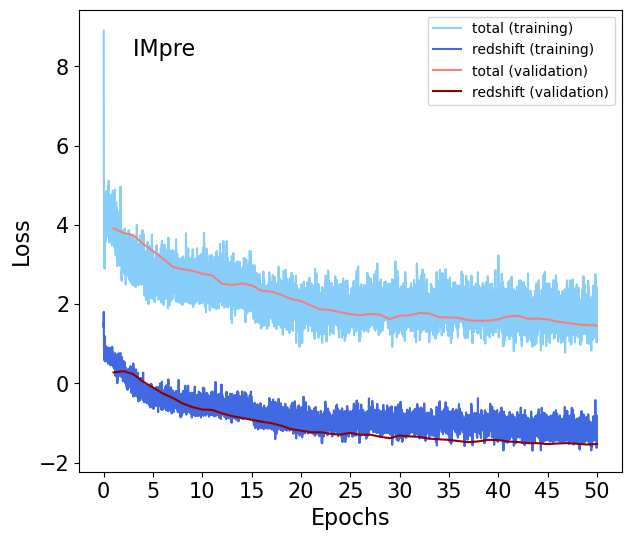

In [28]:
run_name = f'IMpre_MViTv2_gold'
tl, ztl, tvl, zvl = get_losses(run_name,lossdir='/home/g4merz/DeepDISC_Roman_Rubin/models/')
fig,ax = plot_single_loss(tl, ztl, tvl, zvl,epochs=50,ipb=582)
plt.text(0.1, 0.9, 'IMpre ',  transform = ax.transAxes, fontsize=16)
#plt.ylim(-0.5,7)

#plt.savefig(f'/home/g4merz/HSC/plots/{run_name}_loss_curve.png')

Text(0.1, 0.9, 'IMpre ')

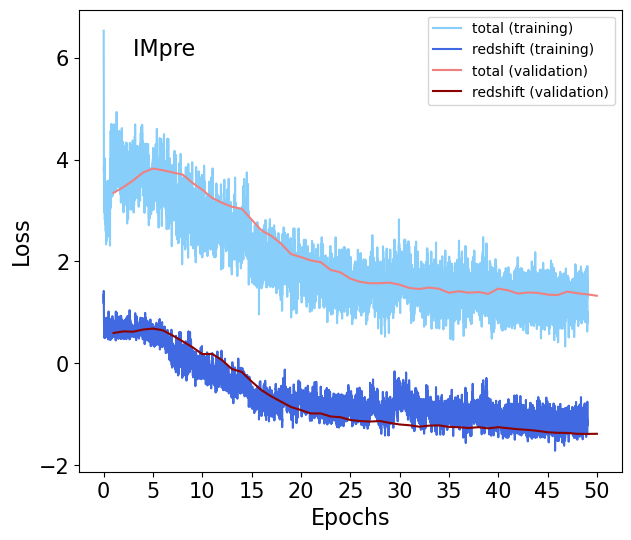

In [36]:
run_name = f'IMpre_MViTv2_gold_combined'
tl, ztl, tvl, zvl = get_losses(run_name,lossdir='/home/g4merz/DeepDISC_Roman_Rubin/models/')
fig,ax = plot_single_loss(tl, ztl, tvl, zvl,epochs=50,ipb=582)
plt.text(0.1, 0.9, 'IMpre ',  transform = ax.transAxes, fontsize=16)
#plt.ylim(-0.5,7)

#plt.savefig(f'/home/g4merz/HSC/plots/{run_name}_loss_curve.png')

(-3.0, 7.0)

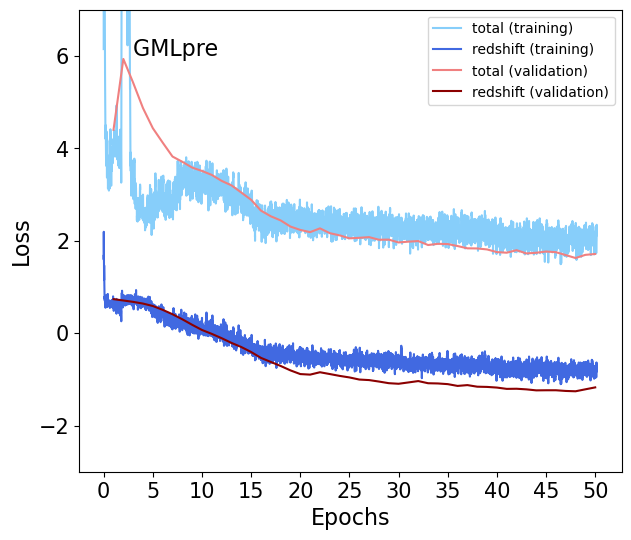

In [16]:
run_name = f'GMLpre_R50_gold'
tl, ztl, tvl, zvl = get_losses(run_name,lossdir='/home/g4merz/DeepDISC_Roman_Rubin/models/')
fig,ax = plot_single_loss(tl, ztl, tvl, zvl,epochs=50,ipb=290)
plt.text(0.1, 0.9, 'GMLpre ',  transform = ax.transAxes, fontsize=16)
plt.ylim(-3,7)

#plt.savefig(f'/home/g4merz/HSC/plots/{run_name}_loss_curve.png')

In [4]:

import qp
import scipy.stats as stats
import math
import seaborn as sns
def outside_box(box,shape):
    if box[0]<0:
        return True
    elif box[1]<0:
        return True
    elif box[2]>shape[1]:
        return True
    elif box[3]>shape[0]:
        return True
    else:
        return False


zgrid = np.linspace(0,11,1100)

truncated = []
truncated_all =[]
for i in range(len(test_ddicts)):
    d = test_ddicts[i]
    shape=(d['height'],d['width'])
    boxes = utils.annotations_to_instances(d['annotations'],shape).gt_boxes.tensor.cpu().numpy()
    for j,box in enumerate(boxes):
        outside = outside_box(box,shape)
        if 'sim' not in d.keys():
            if d['annotations'][j]['redshift']!=-1 and outside:
                truncated.append((i,j,d['annotations'][j]['obj_id']))
            elif outside:
                truncated_all.append((i,j,d['annotations'][j]['obj_id']))

truncated=np.array(truncated)
truncated_all = np.array(truncated_all)

def get_res(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp)
    return [data[key] for key in data.keys()]
    
    

def get_missfilts(ids):
    missfilts = []
    for i, idi in enumerate(ids):
        cnb=0
        mf=[]
        for filt in JADESfilts:
            if dt[dt['ID']==idi][f'{filt}_KRON'].values[0] ==0:
                cnb+=1
                mf.append(filt)

        missfilts.append(mf)

    return missfilts


def get_mi(missfilts):
    mi=[]
    for i,m in enumerate(missfilts):
        if m==np.unique(missfilts)[0]:
            mi.append(i)
    return mi
    
def get_tot(res_name,res_trunc_name,dcat=dtruth_test,truncated=truncated):
    
    zps,zts,ids,scores,gmms = get_res(res_name)
    zps_trunc,zts_trunc,ids_trunc,scores_trunc,gmms_trunc = get_res(res_trunc_name)
    
    #zps,zts,ids,scores,pdfs = res
    #zps_trunc,zts_trunc,ids_trunc,scores_trunc,pdfs_trunc = res_trunc
    
    #What are the dspecztest objects that are not detected?
    nondects_ids = dcat.ID.values[np.nonzero(np.in1d(dcat.ID.values,ids,invert=True))]
    #print(len(nondects_ids))
    
    #How many dspecztest objects that are not detected are truncated?
    truncated_ids = np.unique(truncated[:,2])
    #print(len(np.nonzero(np.in1d(nondects_ids,truncated_ids))[0]))

    #How many originally truncated objects that weren't detected, are now detected?
    orig_trunc_nondects = nondects_ids[np.nonzero(np.in1d(nondects_ids,truncated_ids))[0]]
    
    #objects originally detected that were truncated
    orig_trunc_dects = ids[np.nonzero(np.in1d(ids,truncated_ids))]

    
    zts[np.nonzero(np.in1d(ids,truncated_ids)*np.in1d(ids,ids_trunc))] = zts_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_dects))]
    zps[np.nonzero(np.in1d(ids,truncated_ids)*np.in1d(ids,ids_trunc))] = zps_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_dects))]
    ids[np.nonzero(np.in1d(ids,truncated_ids)*np.in1d(ids,ids_trunc))] = ids_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_dects))]
    gmms[np.nonzero(np.in1d(ids,truncated_ids)*np.in1d(ids,ids_trunc))] = gmms_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_dects))]
    
    zts_tot = np.concatenate([zts,zts_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_nondects))]])
    zps_tot = np.concatenate([zps,zps_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_nondects))]])
    ids_tot = np.concatenate([ids,ids_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_nondects))]])
    gmms_tot = np.concatenate([gmms,gmms_trunc[np.nonzero(np.in1d(ids_trunc,orig_trunc_nondects))]])

    
    return zts_tot, zps_tot, ids_tot, gmms_tot


def get_outlier_inds(zts,zps,DESC_OF):
    met = point_metrics(zts,zps,DESC_OF)
    out_inds = np.where(np.abs(met[0])>0.15)
    return out_inds


def get_tot_common_kfold(kf_zts,kf_zps,kf_ids,kf_gmms):

    zts_common = []
    zps_common = []
    gmms_common = []
    ids_common = list(set.intersection(*map(set, kf_ids)))

    for idi in ids_common:
        inds = []
        for kf in kf_ids:
            inds.append(np.where(kf==idi)[0][0])

        gmm_add = np.hstack([kf_gmm[ind] for ind,kf_gmm in zip(inds,kf_gmms)])
        wi = np.argmax(gmm_add[0])    

        for ind,kf in zip(inds,kf_zps):
            kf[ind] = gmm_add[1][wi]

        zts_common.append(kf_zts[0][inds[0]])
        zps_common.append(kf_zps[0][inds[0]])
        gmms_common.append(gmm_add)

        
    return np.array(zts_common), np.array(zps_common), np.array(ids_common), np.array(gmms_common)


def get_pdfs(gmm,zgrid):
    ws = gmm[:,0]
    mus = gmm[:,1]
    stds = gmm[:,2]
    pdfs = []
    for j in range(len(ws)):
        pdf = np.zeros(len(zgrid))
        for i in range(len(ws[j])):
            pdf += stats.norm.pdf(zgrid, loc=mus[j][i], scale=stds[j][i]) * ws[j][i] 
        pdfs.append(pdf)
    return pdfs



def weight_comb_gmm(gmms_tot,vw):

    for ob in range(gmms_tot.shape[0]):
        for i in range(0,10):
            gml = i*5
            gmu = (i+1)*5
            gmms_tot[ob][0,gml:gmu] = gmms_tot[ob][0,gml:gmu]*vw[i]
    
    zps_tot = []
    for obj in range(gmms_tot.shape[0]):

        wi = np.argmax(gmms_tot[obj][0])    

        zps_tot.append(gmms_tot[obj][1][wi])
        
    #return np.array(zps_tot), gmms_tot
    return gmms_tot



from rail.deepdisc.utils import point_metrics

def plot_rem_scat(zts,zps, errors=None, title_str=f'Complete coverage set', ax=None, ylab=True, 
                  showN=True, DESC_OF=False, color='darkred'):

    met = point_metrics(zts,zps,DESC_OF)

    label = f"Bias: {met[1]:.4f}"    
    label += f"\n$\sigma_{{IQR}}$: {met[3]:.4f}"    
    label += f"\n $\eta$: {met[4]:.4f}"    

    if ax is None:
        #plt.scatter(zts[good_inds],zps[good_inds], s=2)
        if errors is None:
            plt.scatter(zts,zps, s=6,label=label)
        else:
            plt.errorbar(zts,zps,yerr=errors,fmt='.',label=label,c='k')

        plt.title(title_str,fontsize=16)
        leg = plt.legend(handlelength=0, handletextpad=0, fancybox=True, framealpha=0.99, fontsize=13)


        for item in leg.legend_handles:
            item.set_visible(False)


        plt.plot([0,zts.max()+0.3],[0,zts.max()+0.3],color='grey', linestyle='--')
        plt.xlabel('z true',fontsize=17)
        plt.ylabel('z mode',fontsize=17)
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.text(8,1, f'N={len(np.where(np.isfinite(zts))[0])}',fontsize=14)
        
    else:
        if errors is None:
            im=ax.scatter(zts,zps, s=6,label=label,c=color,cmap='plasma_r')
        else:
            im=ax.errorbar(zts,zps,yerr=errors,fmt='.',label=label,c=color,cmap='magma')

        ax.set_title(title_str,fontsize=16)

        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, framealpha=0.99, fontsize=13)

        for item in leg.legend_handles:
            item.set_visible(False)
            item.set_facecolor('none')
            item.set_linewidth('none')
            item.set_label('')

        #ax.plot([0,zts.max()+0.3],[0,zts.max()+0.3],color='grey', linestyle='--')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,linestyle='--',color='grey')
        ax.set_xlabel(r'$z_{\rm spec}$',fontsize=17)
        if ylab:
            ax.set_ylabel(r'$z_{\rm phot}$',fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=15)
        if showN:
            ax.text(6.5,0.7, f'N={len(np.where(np.isfinite(zts))[0])}',fontsize=14)
        plt.tight_layout()
        return im

In [6]:
run_name = "IMpre_MViTv2_gold"

outdir ='/home/g4merz/DeepDISC_Roman_Rubin/estimation/'
fnphot_test = os.path.join(outdir,f'{run_name}_test_outs_phot.npy')

zps_phot_test, zts_phot_test, ids_phot_test, scores_phot_test, gmms_phot_test = get_res(fnphot_test)
pdfs_phot_test = get_pdfs(gmms_phot_test,zgrid)
pdfs_phot_test = np.array(pdfs_phot_test)
zps_phot_test = np.array([zgrid[pdf.argmax()] for pdf in pdfs_phot_test])


/tmp/ipykernel_743167/922268985.py:204: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im=ax.scatter(zts,zps, s=6,label=label,c=color,cmap='plasma_r')
/tmp/ipykernel_743167/922268985.py:226: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 3.0)

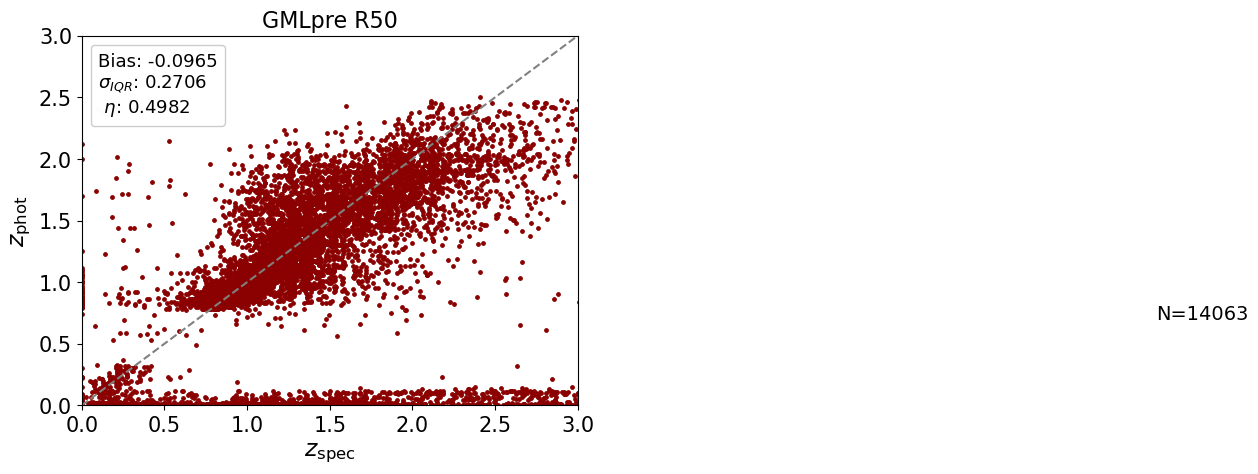

In [21]:
fig,ax = plt.subplots(1,1)
plot_rem_scat(zts_phot_test,zps_phot_test,ax=ax,title_str='GMLpre R50')
plt.xlim(0,3)
plt.ylim(0,3)

In [7]:
dcut = dtruth_test.iloc[np.in1d(dtruth_test.object_id.values,ids_phot_test)]
goldinds=np.where(dcut['mag_i']<25.3)[0]

/tmp/ipykernel_1074858/922268985.py:204: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im=ax.scatter(zts,zps, s=6,label=label,c=color,cmap='plasma_r')
/tmp/ipykernel_1074858/922268985.py:226: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 3.0)

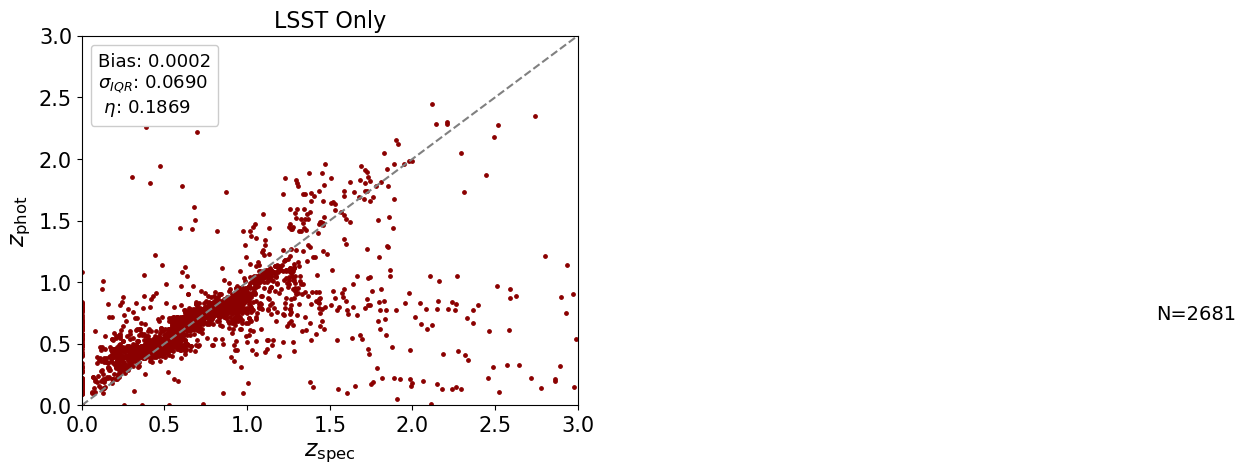

In [8]:
fig,ax = plt.subplots(1,1)
plot_rem_scat(zts_phot_test,zps_phot_test,ax=ax,title_str='LSST Only')
plt.xlim(0,3)
plt.ylim(0,3)

/tmp/ipykernel_1074858/922268985.py:204: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im=ax.scatter(zts,zps, s=6,label=label,c=color,cmap='plasma_r')
/tmp/ipykernel_1074858/922268985.py:226: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 3.0)

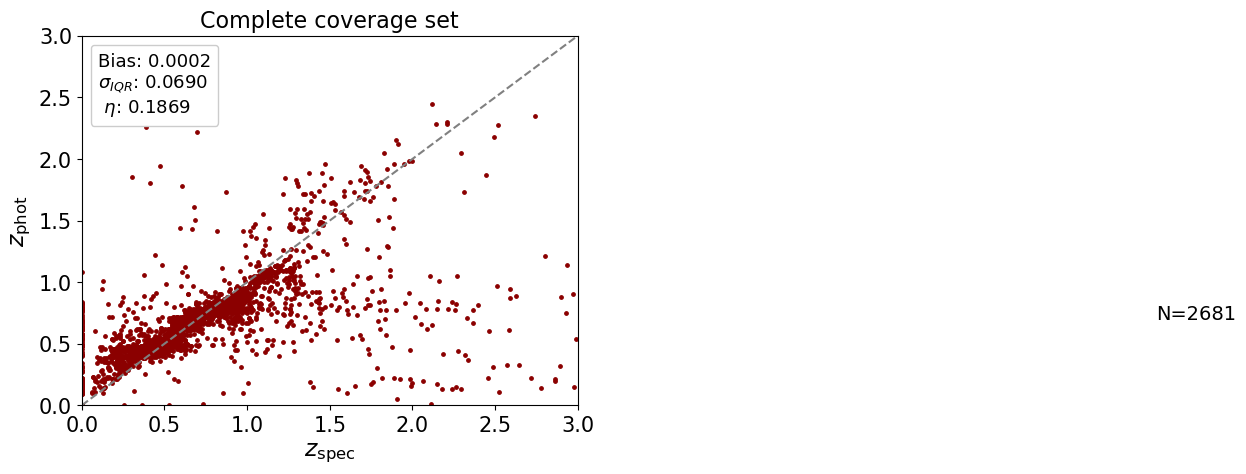

In [9]:
fig,ax = plt.subplots(1,1)
plot_rem_scat(zts_phot_test,zps_phot_test,ax=ax)
plt.xlim(0,3)
plt.ylim(0,3)

In [41]:
dcut = dtruth_test.iloc[np.in1d(dtruth_test.object_id.values,ids_phot_test)]
goldinds=np.where(dcut['mag_i']<25.3)[0]

/tmp/ipykernel_2044330/292851179.py:205: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im=ax.scatter(zts,zps, s=6,label=label,c=color,cmap='plasma_r')
/tmp/ipykernel_2044330/292851179.py:227: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 3.0)

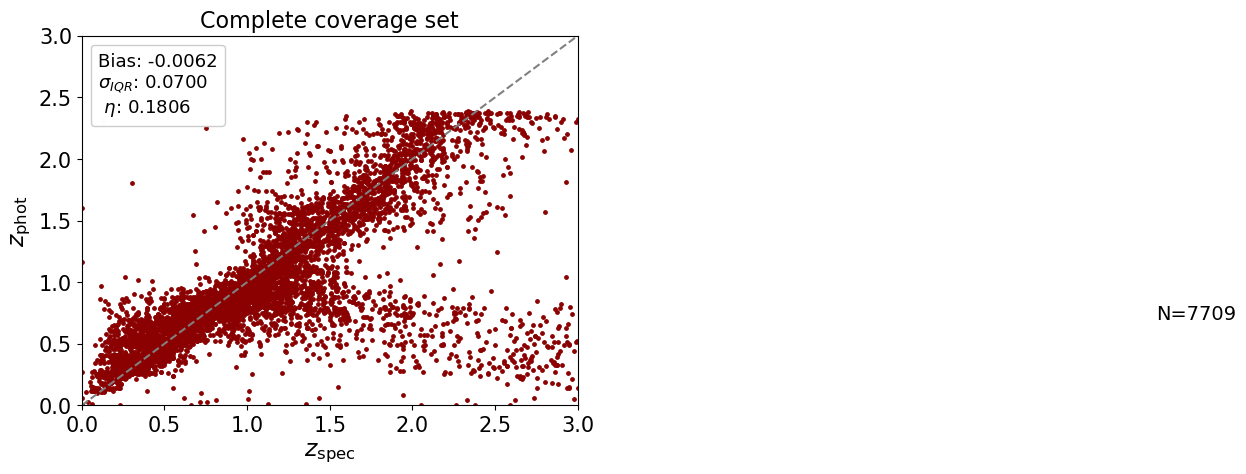

In [44]:
fig,ax = plt.subplots(1,1)
plot_rem_scat(zts_phot_test[goldinds],zps_phot_test[goldinds],ax=ax,DESC_OF=False)
plt.xlim(0,3)
plt.ylim(0,3)

In [10]:
len(goldinds)

2227

In [12]:
len(np.where(dtruth_test['mag_i']<25.3)[0])

8350

In [13]:
2227/8350

0.2667065868263473